In [2]:
#library
import pandas as pd 
from pybliometrics.scopus import ScopusSearch
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import re
import nltk
from nltk.tokenize import sent_tokenize
from nltk import pos_tag
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import wordnet
from collections import Counter
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
pio.renderers.default='notebook'

from sklearn.model_selection import train_test_split
#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel


In [3]:
df = pd.read_csv('audatafinal.csv')

In [3]:
df.head()

,Year,Title,Abstract,Text,y,Label,Probability
0,2023,global mining footprint mapped from high-resol...,"mining is of major economic, environmental and...",global mining footprint mapped from high-resol...,1,water,0.888903
1,2023,soil phosphorus availability and fractionation...,using agricultural wastes as an alternative ph...,soil phosphorus availability and fractionation...,0,soil,0.978994
2,2023,engineered mineralogical interfaces as radionu...,effective capture of fugitive actinides and da...,engineered mineralogical interfaces as radionu...,1,water,0.860382
3,2023,waste-derived catalysts for water electrolysis...,the sustainable production of green hydrogen v...,waste-derived catalysts for water electrolysis...,3,metal,0.952830
4,2023,greywater treatment in a green wall using diff...,green walls in urban environments can be both ...,greywater treatment in a green wall using diff...,0,soil,0.967791


In [4]:
stop_words = set(stopwords.words('English'))


In [5]:
#https://towardsdatascience.com/introduction-to-nlp-part-5b-unsupervised-topic-model-in-python-ab04c186f295


def preprocess_text(text, stop_words, pos_to_keep=None):
    """Preprocess document into normalised tokens."""
    # Tokenise into alphabetic tokens with minimum length of 3
    tokeniser = RegexpTokenizer(r'[A-Za-z]{3,}')
    tokens = tokeniser.tokenize(text)
    
    # Lowercase and tag words with POS tag
    tokens_lower = [token.lower() for token in tokens]
    pos_map = {'J': 'a', 'N': 'n', 'R': 'r', 'V': 'v'}
    pos_tags = pos_tag(tokens_lower)
    
    # Keep tokens with relevant pos
    if pos_to_keep is not None:
        pos_tags =  [token for token in pos_tags if token[1][0] in pos_to_keep]  
    
    # Lemmatise 
    lemmatiser = WordNetLemmatizer()
    lemmas = [lemmatiser.lemmatize(t, pos=pos_map.get(p[0], 'v')) for t, p in pos_tags]
    
    # Remove stopwords
    keywords= [lemma for lemma in lemmas if lemma not in stop_words]
    return keywords

In [6]:
#ref: #https://towardsdatascience.com/introduction-to-nlp-part-5b-unsupervised-topic-model-in-python-ab04c186f295

# Preprocess documents
documents = [preprocess_text(document, stop_words) for document in df.Text]
print("First document:", documents[0], "\n")
# Create word id mappings
id2word = Dictionary(documents)
id2word.filter_extremes(no_below=5)
print("Number of unique words:", len(id2word.token2id.keys()), "\n")
# Transform documents to numbers
corpus = [id2word.doc2bow(document) for document in documents]
print("First document:", corpus[0])




First document: ['global', 'mining', 'footprint', 'map', 'high', 'resolution', 'satellite', 'imagery', 'mining', 'major', 'economic', 'environmental', 'societal', 'consequence', 'yet', 'knowledge', 'understand', 'global', 'footprint', 'still', 'limit', 'produce', 'global', 'mining', 'land', 'use', 'dataset', 'via', 'remote', 'sense', 'analysis', 'high', 'resolution', 'publicly', 'available', 'satellite', 'imagery', 'dataset', 'comprise', 'polygon', 'cover', 'feature', 'like', 'waste', 'rock', 'dump', 'pit', 'water', 'pond', 'tailing', 'dam', 'heap', 'leach', 'pad', 'process', 'milling', 'infrastructure', 'polygon', 'finely', 'contour', 'edge', 'mine', 'feature', 'include', 'space', 'distinguish', 'dataset', 'others', 'employ', 'broad', 'definition', 'mine', 'land', 'hence', 'despite', 'database', 'large', 'date', 'number', 'polygon', 'comparison', 'show', 'relatively', 'low', 'global', 'land', 'use', 'database', 'make', 'freely', 'available', 'support', 'future', 'study', 'global', 'mi

In [7]:
#ref: #https://towardsdatascience.com/introduction-to-nlp-part-5b-unsupervised-topic-model-in-python-ab04c186f295

def compute_coherence(num_topics):
    """Compute coherence score given a number of topics."""
    lda = LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, passes=20, random_state=0)
    cm = CoherenceModel(model=lda, texts=documents, dictionary=id2word, coherence='c_v')
    return cm.get_coherence()

In [9]:
coherence = pd.DataFrame(index=range(2,7), columns=['coherence'])
for i in coherence.index:
    c = compute_coherence(i)
    coherence.loc[i, 'coherence'] = c
coherence

,coherence
2,0.296074
3,0.298532
4,0.339445
5,0.353714
6,0.355085


In [12]:
num_topics = 6
lda = LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, passes=20, random_state=0)
for i in range(num_topics):
    print(f"********** Topic {i+1} **********")
    print(lda.print_topic(i), '\n')

********** Topic 1 **********
0.014*"adsorption" + 0.011*"water" + 0.010*"mine" + 0.010*"removal" + 0.010*"surface" + 0.009*"biochar" + 0.009*"model" + 0.008*"process" + 0.008*"material" + 0.006*"base" 

********** Topic 2 **********
0.017*"wastewater" + 0.015*"treatment" + 0.010*"water" + 0.009*"removal" + 0.008*"sludge" + 0.007*"process" + 0.006*"plant" + 0.006*"nitrogen" + 0.006*"review" + 0.006*"mp" 

********** Topic 3 **********
0.022*"membrane" + 0.019*"soil" + 0.012*"strength" + 0.012*"material" + 0.010*"property" + 0.009*"water" + 0.009*"result" + 0.007*"treatment" + 0.007*"content" + 0.007*"cement" 

********** Topic 4 **********
0.014*"metal" + 0.008*"wastewater" + 0.008*"process" + 0.007*"environmental" + 0.007*"sample" + 0.007*"method" + 0.006*"source" + 0.006*"water" + 0.006*"base" + 0.005*"include" 

********** Topic 5 **********
0.057*"soil" + 0.016*"biochar" + 0.010*"increase" + 0.009*"organic" + 0.009*"food" + 0.008*"plant" + 0.007*"residue" + 0.007*"crop" + 0.007*"pf

In [13]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda, corpus, dictionary=lda.id2word)
vis 

/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in fav

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.001612  0.065548       1        1  28.050870
0     -0.014325 -0.056051       2        1  16.346202
3      0.073132  0.022135       3        1  15.306298
4     -0.108981  0.116206       4        1  14.430213
5      0.135370 -0.012137       5        1  13.278383
2     -0.086807 -0.135701       6        1  12.588034, topic_info=            Term         Freq        Total Category  logprob  loglift
113         soil  1107.000000  1107.000000  Default  30.0000  30.0000
1266    membrane   279.000000   279.000000  Default  29.0000  29.0000
270      biochar   326.000000   326.000000  Default  28.0000  28.0000
861   adsorption   209.000000   209.000000  Default  27.0000  27.0000
875         food   190.000000   190.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
55          show    56.140965   316.804085   Topic6  -5.2401   0.3420
0           also    50.699567   292.962005   Topic6  -5.3420   0.3183
306      organic    43.783387   280.709928   Topic6  -5.4887   0.2144
34           low    43.323716   257.196390   Topic6  -5.4992   0.2913
81     different    42.545701   277.605983   Topic6  -5.5174   0.1968

[457 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
328       1  0.832577     abundance
328       4  0.129512     abundance
328       6  0.018502     abundance
1354      5  0.872720   accordingly
598       1  0.907606  accumulation
...     ...       ...           ...
789       1  0.419752         yield
789       2  0.068068         yield
789       3  0.011345         yield
789       4  0.442441         yield
789       6  0.068068         yield

[1132 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 4, 5, 6, 3])

In [96]:
#get representative documents
def get_document_topics(ldamodel, corpus, texts):
    """Function to find the dominant topics"""
   # Init output
    document_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                document_topics_df = document_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    document_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    document_topics_df = pd.concat([document_topics_df, contents], axis=1)

    document_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', 'Original_Text']

    return document_topics_df


In [127]:
# Group top 5 sentences under each topic
doc_topics_sorted_df = pd.DataFrame()

doc_topic_df_grpd = model_doc.groupby('Dominant_Topic')

#get significant paper of each topic
for i, grp in doc_topic_df_grpd:
    doc_topics_sorted_df = pd.concat([doc_topics_sorted_df, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(40)], 
                                            axis=0)

doc_topics_sorted_df.reset_index(drop=True, inplace=True)
doc_topics_sorted_df.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]
doc_topics_sorted_df

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0,0.9952,"adsorption, water, mine, removal, surface, bio...",variation of copper adsorption with initial ph...
1,0,0.9950,"adsorption, water, mine, removal, surface, bio...",removing methylene blue from water: a study of...
2,0,0.9949,"adsorption, water, mine, removal, surface, bio...",carbon encapsulated iron oxide for simultaneou...
3,0,0.9946,"adsorption, water, mine, removal, surface, bio...",highly effective agro-waste based functional g...
4,0,0.9944,"adsorption, water, mine, removal, surface, bio...",the effect of koh activation and ag nanopartic...
...,...,...,...,...
235,5,0.7456,"water, system, food, energy, sustainable, chan...",sulfate radical-based advanced oxidation proce...
236,5,0.7400,"water, system, food, energy, sustainable, chan...",rational regulation of co-n-c coordination for...
237,5,0.7392,"water, system, food, energy, sustainable, chan...",conversion of plastic waste into fuels: a crit...
238,5,0.7181,"water, system, food, energy, sustainable, chan...",biodiesel production by heterogeneous catalysi...


In [128]:
doc_topics_sorted_df.to_csv('ldadocs.csv',index = False) #representative docs

In [105]:
model_doc = get_document_topics(ldamodel=lda, corpus=corpus, texts=docs)

In [103]:
docs = df.Text.tolist()

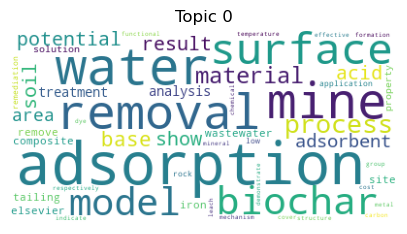

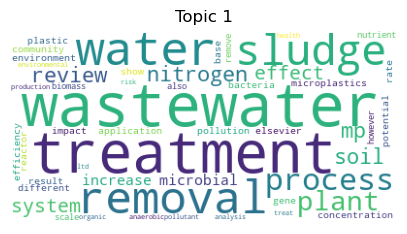

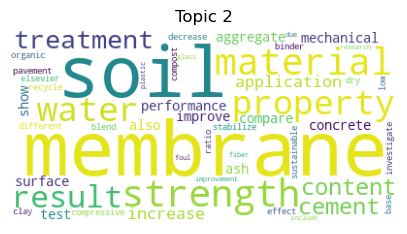

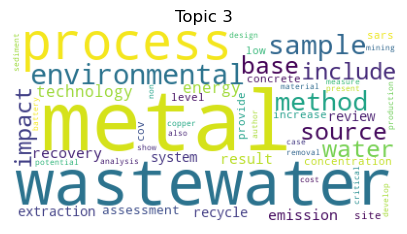

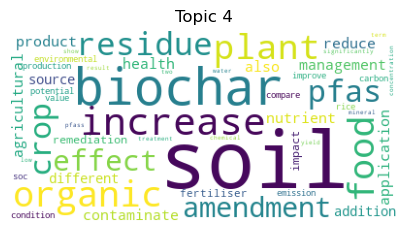

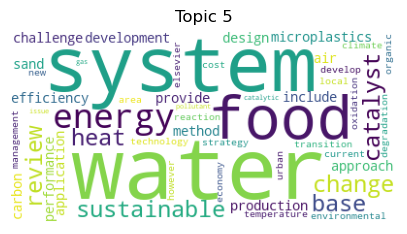

In [124]:
for t in range(lda.num_topics):
    plt.figure(figsize=(5,3))
    plt.imshow(WordCloud(background_color='white').fit_words(dict(lda.show_topic(t, 50))))
    plt.axis("off")
    plt.title("Topic " + str(t))
    plt.show()